This mini-project consists of two components:


1.   **Basic solution** : Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2.   **Advanced solution** : Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model.   

## **Title:Intonation Classification**

# 1 Basic solution


## **Description**
The purpose in this solution is build a model and train it on MLEnd dataset to predict the intonations of the audio files. The steps I followed to come up with this solution are presented below.

Connect to Google Drive.

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Load the 20000 thousand .wav files.

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

Load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and apply label encoding to the intonation column. Label Encoding refers to converting the labels of a column into numeric form, so as to convert it into the machine-readable form, because machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important preprocessing step. Specifically, in our case I manually encoded 'neutral' into 0, 'bored' into 1, 'excited' into 2 and 'question' into 3, based on the expressivity of each intonation.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels["intonation"].replace({"neutral": 0, "bored": 1, "excited": 2, "question": 3}, inplace=True)
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,3
1,0000001.wav,2,S88,2
2,0000002.wav,70,S5,0
3,0000003.wav,2,S85,1
4,0000004.wav,4,S30,2
...,...,...,...,...
19995,0019995.wav,90,S163,2
19996,0019996.wav,10,S99,3
19997,0019997.wav,90,S46,3
19998,0019998.wav,19,S13,0


Define functions to exctract features from our signals and use these features instead predictors. In the following cell, we define a function that extracts four features from an audio signal, namely: Power, Pitch mean, Pitch standard deviation and Fraction of voiced region. Below I define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Considering the task of identifying the intonation of a short audio segment I defined a function that takes a number of files and creates a NumPy array containing the 4 audio signal features used as predictors (X) and their corresponding labels (y) obtained from trainingMLEnd.csv.

In [ ]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

For the purpose of building my model I chose to use and apply the getXy function to extract the 4 features from the first 2000 files of the MLEnd dataset. I considered that 2000 files will representative of the whole dataset, and will be feasible to plot their features efficiently and observe patterns. 

In [ ]:
X,y = getXy(files=files[:2000],labels_file=labels,scale_audio=True)

**#Store my dataset into csv files using numPy.savetxt and load my dataset from csv files using numPy.loadtxt**

In [ ]:
#np.savetxt('data.csv', X, delimiter=',')
#np.savetxt('label.csv', y, delimiter=',', fmt='%d')
#X = np.loadtxt('data.csv', delimiter=',')
#y = np.loadtxt('label.csv', delimiter=',', dtype='int')
#Predictors
print(X)
#Labels
print(y)

[[1.74553939e-02 2.27662371e+02 3.24207665e+01 3.86792453e-01]
 [3.86184087e-02 1.87723934e+02 6.25988127e+01 2.91139241e-01]
 [4.24354413e-02 1.28812251e+02 2.09125286e+01 3.13953488e-01]
 ...
 [2.06223459e-02 1.67011641e+02 4.05206953e+01 4.94949495e-01]
 [2.51654803e-02 2.20345833e+02 4.05375606e+01 4.40476190e-01]
 [3.06051811e-02 2.02338117e+02 4.00733351e+01 2.97520661e-01]]
[1 3 2 ... 2 2 3]


##   **Data visualisation and feature selection**

For the purpose of feature selection I applied an exhaustive approach. Specifically, I selected different combinations of feature subsets and plot them in order to reveal underlying patterns of data.





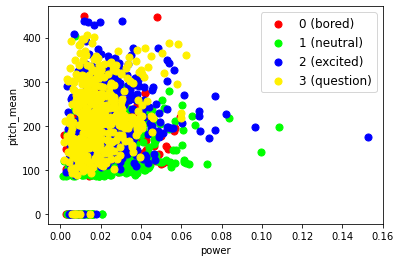

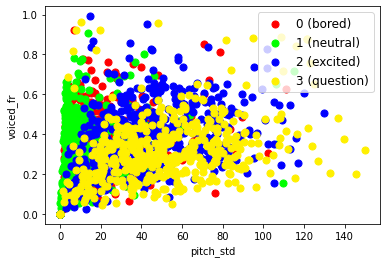

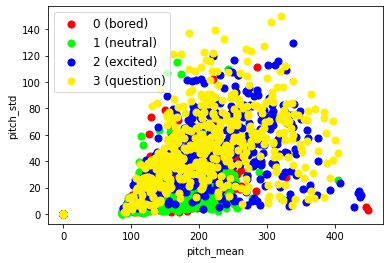

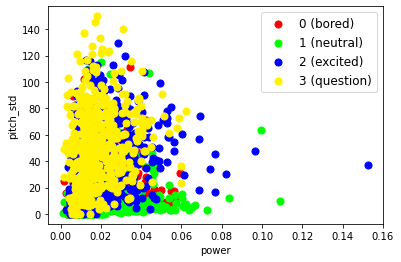

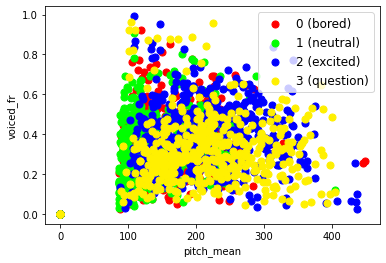

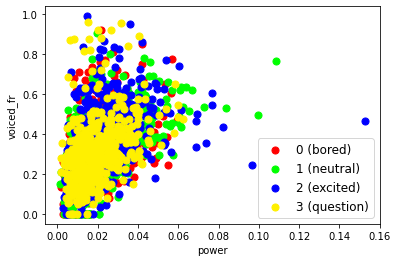

In [ ]:
import matplotlib.pyplot as plt

x_power_pitch_mean = X[:,:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_pitch_mean[y==0,0], x_power_pitch_mean[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_power_pitch_mean[y==1,0], x_power_pitch_mean[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_power_pitch_mean[y==2,0], x_power_pitch_mean[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_pitch_mean[y==3,0], x_power_pitch_mean[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("power")
plt.ylabel("pitch_mean")
plt.legend(fontsize=12)


x_pitch_std_voiced_fr = X[:, 2:4]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_std_voiced_fr[y==0,0], x_pitch_std_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==1,0], x_pitch_std_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==2,0], x_pitch_std_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==3,0], x_pitch_std_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("pitch_std")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)



x_pitch_mean_std = X[:, 1:3]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_mean_std[y==0,0], x_pitch_mean_std[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_pitch_mean_std[y==1,0], x_pitch_mean_std[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_pitch_mean_std[y==2,0], x_pitch_mean_std[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_mean_std[y==3,0], x_pitch_mean_std[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("pitch_mean")
plt.ylabel("pitch_std")
plt.legend(fontsize=12)


x_power_pitch_std = X[:, :3:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_pitch_std[y==0,0], x_power_pitch_std[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_power_pitch_std[y==1,0], x_power_pitch_std[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_power_pitch_std[y==2,0], x_power_pitch_std[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_pitch_std[y==3,0], x_power_pitch_std[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("power")
plt.ylabel("pitch_std")
plt.legend(fontsize=12)


x_pitch_mean_voiced_fr = X[:, 1:4:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_mean_voiced_fr[y==0,0], x_pitch_mean_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==1,0], x_pitch_mean_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==2,0], x_pitch_mean_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==3,0], x_pitch_mean_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("pitch_mean")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)



x_power_voiced_fr = X[:, :4:3]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_voiced_fr[y==0,0], x_power_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'bored'))
scatter = plt.scatter(x_power_voiced_fr[y==1,0], x_power_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'neutral'))
scatter = plt.scatter(x_power_voiced_fr[y==2,0], x_power_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_voiced_fr[y==3,0], x_power_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.xlabel("power")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)

Based on the plots above, it seems that the subset of feaures which is more suitable for our model is the pitch standard deviation and the fraction of voiced region, because in this subset the classes appear to be better separated from the other combination of subsets. Hence, we extract these features and store them in **x_pitch_std_voiced_fr**

The cell below print the shape of our new set of predictors **x_pitch_std_voiced_fr** and labels y.

In [ ]:
print('The shape of X is', x_pitch_std_voiced_fr.shape) 
print('The shape of y is', y.shape)

The shape of X is (2000, 2)
The shape of y is (2000,)


## **Preprocessing Task 1**

Remove any potential item that is not a number (NaN).

In [ ]:
if np.sum(np.isnan(x_pitch_std_voiced_fr)):
  idx = np.isnan(x_pitch_std_voiced_fr).sum(1)>0
  x_pitch_std_voiced_fr = x_pitch_std_voiced_fr[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


# **K-Nearest Neighbors (KNN) Model**

I chose to build a K-Nearest Neighbor (KNN) model using scikit-learn library for the task of identifying the intonation in a short audio signal, using the dataset that I have prepared. KNN is a supervised classification algorithm, which can be used to assign a class to a new sample. In our case, the available classes in our dataset are 4 (neutral, bored, excited and question). KNN keeps all the training data to make future predictions by computing the similarity between an input sample and each training instance. Specifically, it computes the distance between the new data point with every training example using a distance measure. Then model picks K entries in the database which are closest to the new sample. Finally, it does the majority vote and assigns the most common class among those K entries to the new sample.

## **Training and Validation split**

For training and validation task. I used the train/test split function provided by a scikit-learn library. Specifically, the function below takes as an input the predictors(X) the true labels(y) and the test_size, the random_state and stratify. Firstly, I set the test_size to 0.3. This means that our validation dataset will be 30% of the total dataset (600/2000) and the rest go to the training dataset. This is one of the most common splits to estimate the performance of our model. Secondly, I gave an integer value to the random_state parameter, to ensure that the splits are reproducible, hence helped me to verify my output. Finally, I used the stratify parameter to ensure that the training and validation dataset will have the same proportion of samples of each target class.

In [ ]:
#from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_pitch_std_voiced_fr,y,test_size=0.3, random_state=1, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1400, 2), (600, 2), (1400,), (600,))

## **Normalisation**

In the below cell I applied feature normalisation over the training data and then perform normalisation on validation data as well but using the mean and variance of training variables. In this way, I was able to test and evaluate if my model can generalize well to new, unseen data.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

## **Hyperparameter tuning**

In the cell below, I obtained the optimal value of k for my kNN model using elbow method. The optimal value of k is the one (or more) that produces the lowest error rate. 

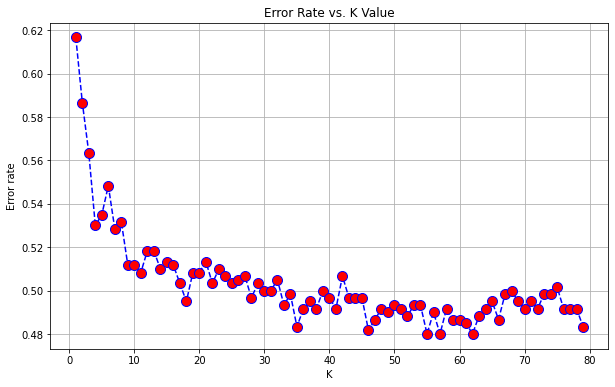

In [ ]:
from sklearn import neighbors
error_rate = []
for i in range(1,80):
 
 knn = neighbors.KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_val)
 error_rate.append(np.mean(pred_i != y_val))

plt.figure(figsize=(10,6))

plt.plot(range(1,80),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error rate')
plt.grid(True)

## **Training and Validation tasks**

In the cell below, I fitted the model on train set and make predictions on the validation set.

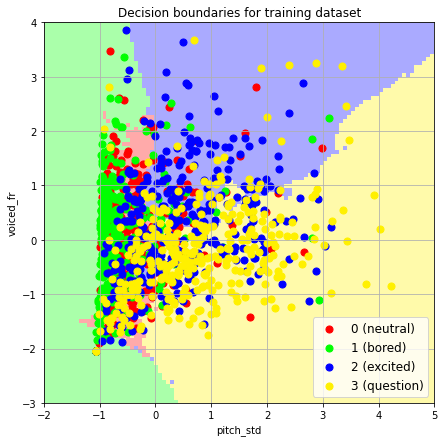

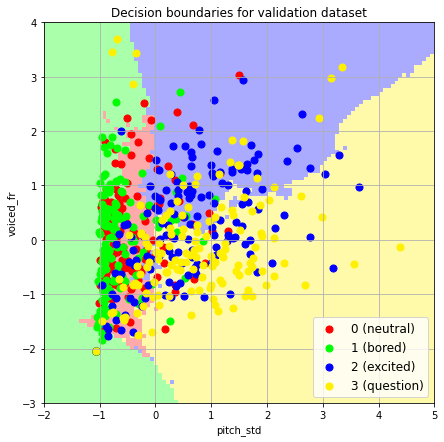

In [ ]:
from matplotlib.colors import ListedColormap

# First create the kNN model with the optimal value k=55.
knn = neighbors.KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)

# Plot the decision regions
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFAAA'])

coor1 = np.linspace(-2, 5, 100)
coor2 = np.linspace(-3, 4, 100)
x1_mesh, x2_mesh = np.meshgrid(coor1, coor2)
yPred = knn.predict(np.c_[x1_mesh.ravel(), x2_mesh.ravel()])
yPred = yPred.reshape(x2_mesh.shape)
plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)

# Here I plot the training dataset
scatter = plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(X_train[y_train==2,0], X_train[y_train==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(X_train[y_train==3,0], X_train[y_train==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.title('Decision boundaries for training dataset')
plt.xlabel('pitch_std')
plt.ylabel('voiced_fr')
plt.legend(fontsize=12)
plt.xlim(-2, 5)
plt.ylim(-3, 4)
plt.grid(True)


plt.figure(figsize=(7, 7))
plt.pcolormesh(x1_mesh, x2_mesh, yPred, cmap=cmap_light)
#Here I plot the validation dataset
scatter = plt.scatter(X_val[y_val==0,0], X_val[y_val==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(X_val[y_val==1,0], X_val[y_val==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(X_val[y_val==2,0], X_val[y_val==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(X_val[y_val==3,0], X_val[y_val==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
plt.title('Decision boundaries for validation dataset')
plt.xlabel('pitch_std')
plt.ylabel('voiced_fr')
plt.legend(fontsize=12)
plt.xlim(-2, 5)
plt.ylim(-3, 4)
plt.grid(True)

## **Performance evaluation**

For the purpose of evaluating the performance of my classifier I used the accuracy metric as well as confusion matrix for both training and validation datasets. Confusion matrix will be a 4x4 table, as there are 4 classes.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_val = knn.predict(X_val)
pred_train = knn.predict(X_train)

#obtain accuracy for training and validation datasets
train_accuracy = accuracy_score(y_train, pred_train)
val_accuracy = accuracy_score(y_val, pred_val)

#plot confusion matrix for training and validation datasets
train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=pred_train)
val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=pred_val)
print('Training accuracy : {}'.format(train_accuracy))
print('Validation accuracy : {}'.format(val_accuracy))
print('Confusion matrix for training : {}'.format(train_confusion_matrix))
print('Confusion matrix for validation : {}'.format(val_confusion_matrix))

Training accuracy : 0.5228571428571429
Validation accuracy : 0.52
Confusion matrix for training : [[174 133  40  31]
 [ 94 218  23  22]
 [ 76  23 136 102]
 [ 47  14  63 204]]
Confusion matrix for validation : [[72 58 21 11]
 [41 95 11  6]
 [24  5 61 55]
 [20  4 32 84]]


# **Conclusions**

The stucture of the audio signal features in data visualisation section revealed that the data is not easily seperable by a linear classifier. Hence, I proceed to find the best non linear classifier for our purpose. For selecting the best model I trained different classifiers such as kNN, Naive Bayes, SVM and estimated their accuracy performance. kNN and SVM were achieving the same accuracy performance more or less. However, SVM is an efficient approach when the feature vector is high dimensional. Thus, I decided to choose kNN, because it is simple a approach for low dimension dataset and efficient for multiclass classifications.
As I observed in Performance evaluation section the accuracy of my model for training dataset and validation dataset is almost the same. This shows that it does not overfit, but if I had chosen a small value for k, the model would possibly overfit, because it would increase the complexity of it. Also, the confusion matrix shows that the intonation that is classified correctly (True Positives) the most is the bored intonation.

# 2 Advanced solution

## **Description**

This solution is to introduce and explore the features of a new intonation from audio files that I recorded and prepared myself. This new intonation is the angry intonation. The purpose of this solution is build a model, trained on both MLEnd and myTraining dataset, and check the features of this new class, how it differentiates from the other intonations and if I can achieve a high classification accuracy on this class.

Connect to Google Drive

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Mounted at /content/drive


Get the 20000 wav files from TrainingMLEnd dataset.

In [ ]:
files1 = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files1)

20000

Get the 10 .wav files from my dataset.

In [ ]:
files2 = glob.glob('/content/drive/MyDrive/myTraining/*.wav')
len(files2)

20

This figure is the number of items in my dataset. I can listen to 5 random audio files:

In [ ]:
for _ in range(5):
  n = np.random.randint(10)
  display(ipd.Audio(files2[n]))

Load the contents of 'trainingMLEnd.csv' into a pandas DataFrame and apply label encoding to the intonation column. Label Encoding refers to converting the labels of a column into numeric form, so as to convert it into the machine-readable form, because machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important preprocessing step. Specifically, in our case I manually encoded 'neutral' into 0, 'bored' into 1, 'excited' into 2 and 'question' into 3, based on the expressivity of each intonation.

In [ ]:
labels1 = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels1["intonation"].replace({"neutral": 0, "bored": 1, "excited": 2, "question": 3}, inplace=True)
labels1

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,3
1,0000001.wav,2,S88,2
2,0000002.wav,70,S5,0
3,0000003.wav,2,S85,1
4,0000004.wav,4,S30,2
...,...,...,...,...
19995,0019995.wav,90,S163,2
19996,0019996.wav,10,S99,3
19997,0019997.wav,90,S46,3
19998,0019998.wav,19,S13,0


Now load the contents of 'myTrainingDataset.csv' into a pandas DataFrame and apply label encoding to the intonation column. Specifically I encoded the 'angry' intonation into 4. Again, based on the expressivity of the intonation.

In [ ]:
labels2 = pd.read_csv('myTrainingDataset.csv')
labels2["intonation"].replace({"angry": 4}, inplace=True)
labels2

,File ID,digit_label,participant,intonation
0,angry0.wav,0,Me,4
1,angry1.wav,1,Me,4
2,angry2.wav,2,Me,4
3,angry3.wav,3,Me,4
4,angry4.wav,4,Me,4
5,angry5.wav,5,Me,4
6,angry6.wav,6,Me,4
7,angry7.wav,7,Me,4
8,angry8.wav,8,Me,4
9,angry9.wav,9,Me,4


Define functions to exctract features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely: Power, Pitch mean, Pitch standard deviation and Fraction of voiced region.
Below I define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

Considering the task of identifying the intonation of a short audio segment, including the new one, I defined a function that takes a number of files and creates a NumPy array containing the 4 audio signal features used as predictors (X) and their corresponding labels (y) obtained from trainingMLEnd.csv and myTrainingDataset.csv.

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  Xtrain,ytrain =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    checkSingleDigit = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    yi = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and checkSingleDigit > 9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      Xtrain.append(xi)
      ytrain.append(yi)
  return np.array(Xtrain),np.array(ytrain)

For the purpose of building my model I chose to use and apply the getXy function to extract the 4 features from the first 250 files of the MLEnd dataset. However, the first 250 files contain numerals outside the 0-9 range, which I discarded.

In [ ]:
X1,y1 = getXy(files=files1[:250],labels_file=labels1,scale_audio=True, onlySingleDigit=True)

print(X1.shape)

(88, 4)


As above, I applied the getXy function to extract the 4 features from myTraining dataset, which contains 20 audio files with numerals inside the 0-9 range.

In [ ]:
X2,y2 = getXy(files=files2[:20],labels_file=labels2,scale_audio=True, onlySingleDigit=True)

print(X2.shape)

(20, 4)


I concatenated the predictors (X1) from MLEnd dataset with the predictors (X2) from myTraining dataset. Also, I concatenated the labels (y1) with the labels (y2) from MLEnd dataset and myTrainingDataset respectively.

In [ ]:
X = np.concatenate((X1, X2))
y = np.concatenate((y1, y2), axis=None)

**#Store my dataset into csv files using numPy.savetxt and load my dataset from csv files using numPy.loadtxt**

In [ ]:
#np.savetxt('dataset.csv', X, delimiter=',')
#np.savetxt('labels.csv', y, delimiter=',', fmt='%d')
#X = np.loadtxt('dataset.csv', delimiter=',')
#y = np.loadtxt('labels.csv', delimiter=',', dtype='int')

Print the new shape of predictors (X) and labels (y).

In [ ]:
print(X.shape)
print(y.shape)

(108, 4)
(108,)


##   **Data visualisation and feature selection**

For the purpose of feature selection I applied an exhaustive approach. Specifically, I selected different combinations of feature subsets and plot them in order to reveal underlying patterns of data.

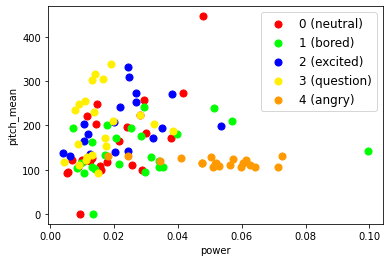

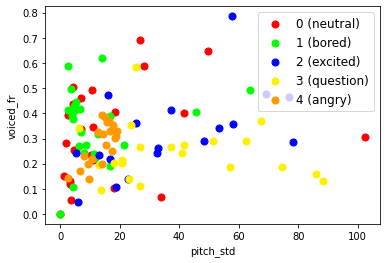

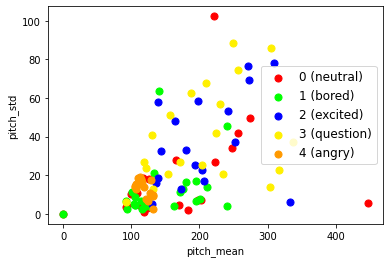

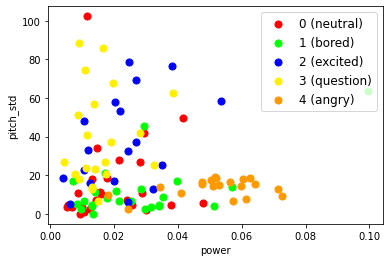

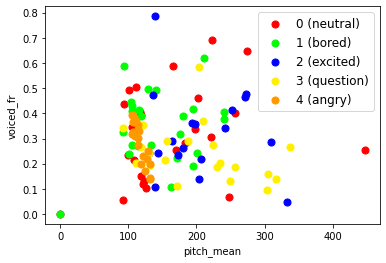

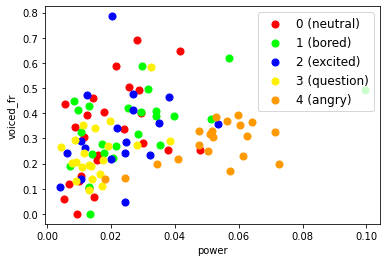

In [ ]:
import matplotlib.pyplot as plt

x_power_pitch_mean = X[:,:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_pitch_mean[y==0,0], x_power_pitch_mean[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_power_pitch_mean[y==1,0], x_power_pitch_mean[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_power_pitch_mean[y==2,0], x_power_pitch_mean[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_pitch_mean[y==3,0], x_power_pitch_mean[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_power_pitch_mean[y==4,0], x_power_pitch_mean[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))
plt.xlabel("power")
plt.ylabel("pitch_mean")
plt.legend(fontsize=12)


x_pitch_std_voiced_fr = X[:, 2:4]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_std_voiced_fr[y==0,0], x_pitch_std_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==1,0], x_pitch_std_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==2,0], x_pitch_std_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==3,0], x_pitch_std_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_pitch_std_voiced_fr[y==4,0], x_pitch_std_voiced_fr[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))

plt.xlabel("pitch_std")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)



x_pitch_mean_std = X[:, 1:3]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_mean_std[y==0,0], x_pitch_mean_std[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_pitch_mean_std[y==1,0], x_pitch_mean_std[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_pitch_mean_std[y==2,0], x_pitch_mean_std[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_mean_std[y==3,0], x_pitch_mean_std[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_pitch_mean_std[y==4,0], x_pitch_mean_std[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))
plt.xlabel("pitch_mean")
plt.ylabel("pitch_std")
plt.legend(fontsize=12)


x_power_pitch_std = X[:, :3:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_pitch_std[y==0,0], x_power_pitch_std[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_power_pitch_std[y==1,0], x_power_pitch_std[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_power_pitch_std[y==2,0], x_power_pitch_std[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_pitch_std[y==3,0], x_power_pitch_std[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_power_pitch_std[y==4,0], x_power_pitch_std[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))
plt.xlabel("power")
plt.ylabel("pitch_std")
plt.legend(fontsize=12)


x_pitch_mean_voiced_fr = X[:, 1:4:2]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_pitch_mean_voiced_fr[y==0,0], x_pitch_mean_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==1,0], x_pitch_mean_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==2,0], x_pitch_mean_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==3,0], x_pitch_mean_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_pitch_mean_voiced_fr[y==4,0], x_pitch_mean_voiced_fr[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))
plt.xlabel("pitch_mean")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)



x_power_voiced_fr = X[:, :4:3]

plt.figure(figsize=(6, 4))

scatter = plt.scatter(x_power_voiced_fr[y==0,0], x_power_voiced_fr[y==0,1], s=50 , color= '#FF0000', label='{:d} ({:s})'.format(0, 'neutral'))
scatter = plt.scatter(x_power_voiced_fr[y==1,0], x_power_voiced_fr[y==1,1], s=50 , color= '#00FF00', label='{:d} ({:s})'.format(1, 'bored'))
scatter = plt.scatter(x_power_voiced_fr[y==2,0], x_power_voiced_fr[y==2,1], s=50 , color= '#0000FF', label='{:d} ({:s})'.format(2, 'excited'))
scatter = plt.scatter(x_power_voiced_fr[y==3,0], x_power_voiced_fr[y==3,1], s=50 , color= '#FFF000', label='{:d} ({:s})'.format(3, 'question'))
scatter = plt.scatter(x_power_voiced_fr[y==4,0], x_power_voiced_fr[y==4,1], s=50 , color= '#FF9900', label='{:d} ({:s})'.format(4, 'angry'))

plt.xlabel("power")
plt.ylabel("voiced_fr")
plt.legend(fontsize=12)

As we are concerned about the angry intonation, I would select the pair of power and pitch mean features to train, because there, the angry intonation appears to be seperated from the other classes.

## **Preprocessing Task 1**

Remove any potential item that is not a number (NaN).

In [ ]:
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


## **Train/test split: 4 features**

For training and validation task, I used the train/test split function provided by a scikit-learn library. Specifically, the function below takes as an input the predictors(X) the true labels(y) and the test_size, the random_state and stratify. Firstly, I set the test_size to 0.2, as I wanted to have as many data as possible to train my model effectively. This means that our validation dataset will be 20% of the total dataset (22/108) and the rest go to the training dataset. Secondly, I gave an integer value to the random_state parameter, to ensure that the splits are reproducible, hence helped me to verify my output. Thirdly, I used the stratify parameter to ensure that the training and validation dataset will have the same proportion of samples of each target class and finally, I set the shuffle parameter to true, because the items of myTraining dataset where all added in the end of the X array after concatenation.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=1, stratify=y, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((86, 4), (22, 4), (86,), (22,))

## **Normalisation**

In the below cell I applied feature normalisation over the training data and then perform normalisation on validation data as well but using the mean and variance of training variables. In this way, I was able to test and evaluate if my model can generalize well to new, unseen data.

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

## **Model Selection**

In the cell below, I train and compare different models and compare them in order to find which one classifies the 'angry' intonation more accurately given the same train/test split.

### **Support Vector Machines (SVM)**

In [ ]:
#Svm model
from sklearn import svm
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

After several tries, I found that the best value for C parameter is 1

### **Performance evaluation: SVM**

For the purpose of evaluating the performance of my classifier I used the accuracy metric as well as confusion matrix for both training and validation datasets. Confusion matrix will be a 5x5 table, as there are 5 classes.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_val = model.predict(X_val)
pred_train = model.predict(X_train)

#obtain accuracy for training and validation datasets
train_accuracy = accuracy_score(y_train, pred_train)
val_accuracy = accuracy_score(y_val, pred_val)

#plot confusion matrix for training and validation datasets
train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=pred_train)
val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=pred_val)
print('Training accuracy : {}'.format(train_accuracy))
print('Validation accuracy : {}'.format(val_accuracy))
print('Confusion matrix for training : {}'.format(train_confusion_matrix))
print('Confusion matrix for validation : {}'.format(val_confusion_matrix))

Training accuracy : 0.627906976744186
Validation accuracy : 0.5909090909090909
Confusion matrix for training : [[13  5  1  1  0]
 [ 6 11  1  0  1]
 [ 2  2  6  4  0]
 [ 4  1  2 10  0]
 [ 2  0  0  0 14]]
Confusion matrix for validation : [[4 1 0 0 0]
 [2 3 0 0 0]
 [1 1 0 2 0]
 [1 0 1 2 0]
 [0 0 0 0 4]]


### **Gaussian Naive Bayes**

Training Gaussian Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

## **Performance evaluation: GNB**

In [ ]:
pred_val = gnb.predict(X_val)
pred_train = gnb.predict(X_train)

#obtain accuracy for training and validation datasets
train_accuracy = accuracy_score(y_train, pred_train)
val_accuracy = accuracy_score(y_val, pred_val)

#plot confusion matrix for training and validation datasets
train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=pred_train)
val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=pred_val)
print('Training accuracy : {}'.format(train_accuracy))
print('Validation accuracy : {}'.format(val_accuracy))
print('Confusion matrix for training : {}'.format(train_confusion_matrix))
print('Confusion matrix for validation : {}'.format(val_confusion_matrix))

Training accuracy : 0.5465116279069767
Validation accuracy : 0.5
Confusion matrix for training : [[10  5  2  2  1]
 [ 7  8  1  1  2]
 [ 2  2  5  5  0]
 [ 1  3  3 10  0]
 [ 2  0  0  0 14]]
Confusion matrix for validation : [[1 3 0 1 0]
 [0 4 0 0 1]
 [0 2 0 2 0]
 [1 0 1 2 0]
 [0 0 0 0 4]]


## **Train/test split: 2 features**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_power_pitch_mean,y,test_size=0.2, random_state=1, stratify=y, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((86, 2), (22, 2), (86,), (22,))

## **Normalisation**

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

## **Model Selection**

### **Support Vector Machines (SVM)**

Training SVM model

In [ ]:
#Svm model
from sklearn import svm
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### **Performance evaluation: SVM**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

pred_val = model.predict(X_val)
pred_train = model.predict(X_train)

#obtain accuracy for training and validation datasets
train_accuracy = accuracy_score(y_train, pred_train)
val_accuracy = accuracy_score(y_val, pred_val)

#plot confusion matrix for training and validation datasets
train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=pred_train)
val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=pred_val)
print('Training accuracy : {}'.format(train_accuracy))
print('Validation accuracy : {}'.format(val_accuracy))
print('Confusion matrix for training : {}'.format(train_confusion_matrix))
print('Confusion matrix for validation : {}'.format(val_confusion_matrix))

Training accuracy : 0.5116279069767442
Validation accuracy : 0.5
Confusion matrix for training : [[16  2  2  0  0]
 [11  7  1  0  0]
 [ 9  1  3  1  0]
 [11  1  0  5  0]
 [ 2  1  0  0 13]]
Confusion matrix for validation : [[3 2 0 0 0]
 [3 2 0 0 0]
 [3 0 0 1 0]
 [2 0 0 2 0]
 [0 0 0 0 4]]


### **Gaussian Naive Bayes**

Training Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### **Performance evaluation: GNB**

In [ ]:
pred_val = gnb.predict(X_val)
pred_train = gnb.predict(X_train)

#obtain accuracy for training and validation datasets
train_accuracy = accuracy_score(y_train, pred_train)
val_accuracy = accuracy_score(y_val, pred_val)

#plot confusion matrix for training and validation datasets
train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=pred_train)
val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=pred_val)
print('Training accuracy : {}'.format(train_accuracy))
print('Validation accuracy : {}'.format(val_accuracy))
print('Confusion matrix for training : {}'.format(train_confusion_matrix))
print('Confusion matrix for validation : {}'.format(val_confusion_matrix))

Training accuracy : 0.45348837209302323
Validation accuracy : 0.5909090909090909
Confusion matrix for training : [[11  1  4  3  1]
 [ 9  4  1  2  3]
 [ 7  1  4  2  0]
 [ 7  2  2  6  0]
 [ 2  0  0  0 14]]
Confusion matrix for validation : [[4 0 1 0 0]
 [3 1 0 0 1]
 [1 0 1 2 0]
 [1 0 0 3 0]
 [0 0 0 0 4]]


**Because the validation set for GNB is to small it does not adequately represent the probability distribution of the data. As a result, it shows that validation accuracy is greater than training accuracy**

## **Conclusion**

To conclude, despite having an average overall classification accuracy for both models, trained with 4 features, they did an excellent job on the classification of the angry intonation. However, as I am concerned on finding the best classification accuracy only for angry intonation, I would chose the SVM model trained with 2 features only, as it classifies it correctly again, because we occupy less space and also less dimensions lead to less computation and training time.